In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

In [2]:
STOCK = "OTKAR.IS"
PERIOD_HISTORY = "1y"
PERIOD_ESTIMATION = 30
PERIOD_CV = "5 days"
PERIOD_HORIZON = "45 days"

In [3]:
tick = yf.Ticker(STOCK)

In [4]:
hist = tick.history(period=PERIOD_HISTORY, actions=False)
hist["Date"] = hist.index
hist = hist.set_index([[i for i in range(len(hist))]])

In [5]:
hist.head(5)

,Open,High,Low,Close,Volume,Date
0,149.738432,151.494618,147.889809,149.461136,99380,2020-01-06
1,150.200578,151.494608,147.982236,150.385437,62420,2020-01-07
2,148.629253,150.015720,146.965490,147.889801,37538,2020-01-08
3,150.200586,150.200586,147.797371,149.091415,72772,2020-01-09
4,149.553562,149.738422,147.427644,147.520081,76576,2020-01-10


In [6]:
hist.describe()["Close"]

count    251.000000
mean     159.691273
std       48.081530
min       94.834335
25%      137.500000
50%      146.500000
75%      160.600006
max      391.799988
Name: Close, dtype: float64

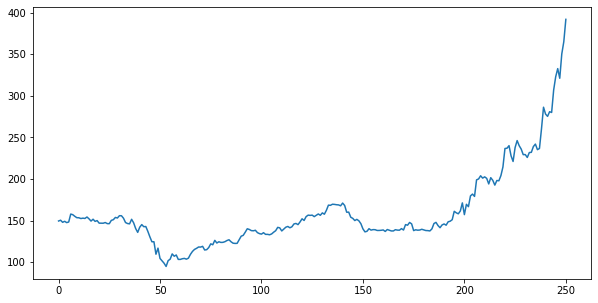

In [7]:
hist["Close"].plot(figsize=(10, 5))

plt.savefig("out/stock_prices.png")

In [8]:
data = hist[["Date", "Close"]]
data = data.rename(columns={"Date": "ds", "Close": "y"})

data.head(5)

,ds,y
0,2020-01-06,149.461136
1,2020-01-07,150.385437
2,2020-01-08,147.889801
3,2020-01-09,149.091415
4,2020-01-10,147.520081


In [9]:
model = Prophet()
model.add_country_holidays(country_name="TR")
model.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = model.make_future_dataframe(periods=PERIOD_ESTIMATION)
preds = model.predict(future)

In [11]:
preds[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(5)

,ds,yhat,yhat_lower,yhat_upper
276,2021-02-01,366.450434,350.158582,382.213112
277,2021-02-02,370.379068,351.501556,386.213425
278,2021-02-03,373.223928,356.691816,389.886671
279,2021-02-04,372.652434,355.770644,388.200384
280,2021-02-05,374.498629,357.680417,391.568241


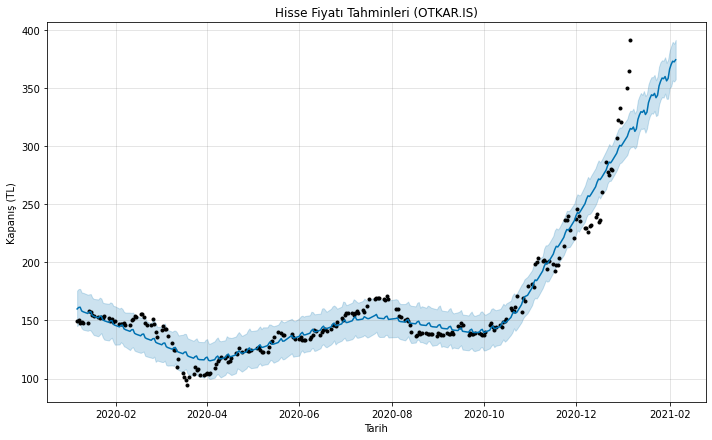

<Figure size 432x288 with 0 Axes>

In [12]:
model.plot(preds)

plt.title("Hisse Fiyatı Tahminleri ({})".format(STOCK))
plt.xlabel("Tarih")
plt.ylabel("Kapanış (TL)")
plt.show()

#plt.savefig("out/stock_preds.png")

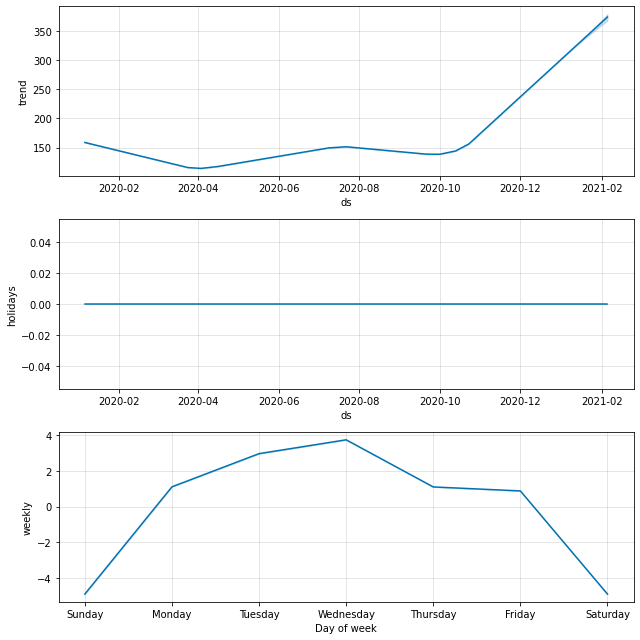

In [13]:
model.plot_components(preds)
plt.show()

#plt.savefig("out/stock_components.png")

In [14]:
cv = cross_validation(model, period=PERIOD_CV, horizon=PERIOD_HORIZON, parallel="processes")

cv.head(5)

INFO:fbprophet:Making 38 forecasts with cutoffs between 2020-05-21 00:00:00 and 2020-11-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1408c2790>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-22,135.332462,128.834123,141.649426,137.699997,2020-05-21
1,2020-05-27,139.526203,132.482467,146.553205,138.300003,2020-05-21
2,2020-05-28,138.277274,131.700523,145.300274,135.500000,2020-05-21
3,2020-05-29,139.133339,132.156445,145.662208,134.300003,2020-05-21
4,2020-06-01,141.207622,134.388412,148.365987,133.699997,2020-05-21


In [15]:
pm = performance_metrics(cv)

pm.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,5 days,323.333783,17.981484,13.302628,0.080571,0.064987,0.470822
1,6 days,327.823907,18.105908,13.535306,0.082395,0.060864,0.464879
2,7 days,360.289725,18.981299,14.136748,0.085845,0.073438,0.457854
3,8 days,392.809950,19.819434,14.864058,0.090176,0.068997,0.441724
4,9 days,450.647260,21.228454,15.974737,0.095936,0.075236,0.424288


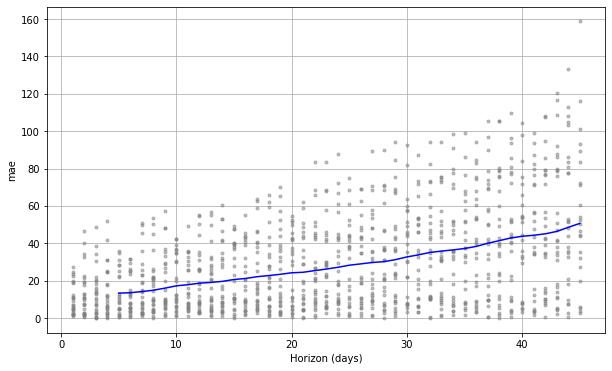

In [19]:
kpi = plot_cross_validation_metric(cv, metric="mae")